# Design Brief 

A hospital is looking into ways to predict whether diabetic patients will be readmitted within 30 days.

Hospital readmissions increase the healthcare costs and negatively influence hospitals' reputation. In this context, predicting readmissions in early stages becomes very important since it allows prompting great attention to patients with high risk of readmission, which further leverages the healthcare system and saves healthcare expenditures.

The hospital has heard about the potential of introducing an automated ML system to make this prediction. They are giving you access to a large clinical database and they are asking you to do some exploration and present a summary of your findings: can they imagine automating this possibility? If not, why? If yes, what would they need to do and consider?

We are asking you to explore the dataset (below) to answer this question. Feel free to use any tool you would typically use if you want to actually look into the dataset and/or model. 
Can you speak out loud to explain to us what you would do to answer the question?





# Set-up

## Load required libraries

In [ ]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes 
%matplotlib inline
# from IPython.display import Markdown, display

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV 

from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

np.random.seed(1)

# Dataset

Load the data.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/pablobiedma/datasets/main/final_diabetes.csv")
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,False,False,False,False,NO,0,0,109,widowed,1
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,False,False,False,False,>30,1,0,151,single,1
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,False,False,True,True,NO,0,0,Missing,widowed,1
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,False,False,False,False,NO,0,0,223,married,1
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,False,False,False,False,NO,0,0,284,divorced,1


In [ ]:
print("Number of records: " + str(df.shape[0]))
print("Number of features: " + str(df.shape[1]))

Number of records: 101766
Number of features: 28


## Dataset description

The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |


# Your Exploration: 

# A1

In [ ]:
print(df.skew())

time_in_hospital       1.133999
num_lab_procedures    -0.236544
num_procedures         1.316415
num_medications        1.326672
number_diagnoses      -0.876746
medicare               0.777869
medicaid               5.084219
had_emergency          2.462985
had_inpatient_days     0.697104
had_outpatient_days    1.810121
readmit_binary         0.156960
readmit_30_days        2.467071
region                 3.455616
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


# A2

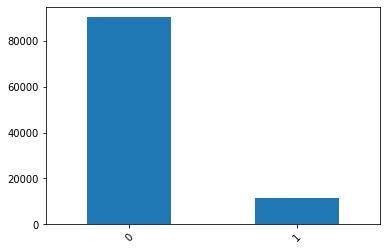

In [ ]:
df["readmit_30_days"].value_counts().plot(kind='bar', rot=45);

# A3

In [ ]:
df["gender"].value_counts() # counts

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

# A4

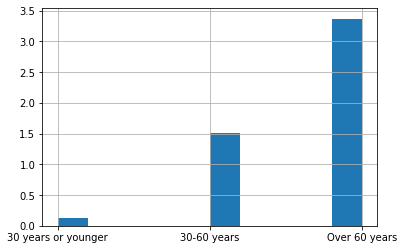

In [ ]:
df["age"].hist(density=1)

# A5

In [ ]:
df["readmit_30_days"].value_counts(normalize=True) # frequencies

0    0.888401
1    0.111599
Name: readmit_30_days, dtype: float64

# A6
<!-- Examine how much the label frequencies vary within each group defined by race: -->

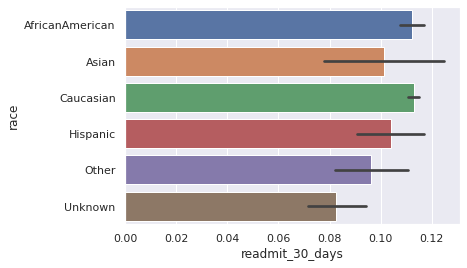

In [ ]:
sns.set()
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95)

# A7
<!-- Correlations between attributes -->

                     time_in_hospital  num_lab_procedures  num_procedures  \
time_in_hospital             1.000000            0.318450        0.191472   
num_lab_procedures           0.318450            1.000000        0.058066   
num_procedures               0.191472            0.058066        1.000000   
num_medications              0.466135            0.268161        0.385767   
number_diagnoses             0.220186            0.152773        0.073734   
medicare                     0.020257           -0.015672       -0.056995   
medicaid                    -0.002151           -0.010401       -0.023350   
had_emergency               -0.004298            0.005203       -0.050575   
had_inpatient_days           0.087825            0.037610       -0.073512   
had_outpatient_days         -0.018331           -0.029862       -0.033064   
readmit_binary               0.051289            0.039253       -0.044748   
readmit_30_days              0.044199            0.020364       -0.012227   

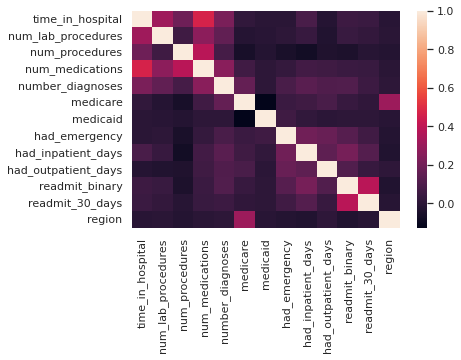

In [ ]:
print(df.corr())
sns.heatmap(df.corr());

# A8
<!-- Missing Values -->


In [ ]:
pd_data = df
pd_data = pd_data.replace('Missing',np.NaN)
print("Number of missing values for each attribute: ", pd_data.isnull().sum())

Number of missing values for each attribute:  race                            0
gender                          0
age                             0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
primary_diagnosis               0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
insulin                         0
change                          0
diabetesMed                     0
medicare                        0
medicaid                        0
had_emergency                   0
had_inpatient_days              0
had_outpatient_days             0
readmitted                      0
readmit_binary                  0
readmit_30_days                 0
weight                      21832
marital_status                  0
region                          0
dt

Tabular representation of missing values.

In [ ]:
df.isnull()
#Filling missing values using fillna(), replace() and interpolate() :

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101762,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101763,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
101764,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# A9

In [ ]:
df = df.dropna()
pd_data = df
print("Number of missing values for each attribute: ", pd_data.isnull().sum())

Number of missing values for each attribute:  race                        0
gender                      0
age                         0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
primary_diagnosis           0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
insulin                     0
change                      0
diabetesMed                 0
medicare                    0
medicaid                    0
had_emergency               0
had_inpatient_days          0
had_outpatient_days         0
readmitted                  0
readmit_binary              0
readmit_30_days             0
weight                      0
marital_status              0
region                      0
dtype: int64


# A10
<!-- Duplicated values -->

In [ ]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
101761    False
101762    False
101763    False
101764    False
101765    False
Length: 101766, dtype: bool

# A11
<!-- Drop any duplicates that might exist. -->

In [ ]:
df.drop_duplicates()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days,weight,marital_status,region
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,False,False,False,False,NO,0,0,109,widowed,1
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,False,False,False,False,>30,1,0,151,single,1
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,False,False,True,True,NO,0,0,Missing,widowed,1
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,False,False,False,False,NO,0,0,223,married,1
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,False,False,False,False,NO,0,0,284,divorced,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,Over 60 years,Other,Emergency,3,Missing,51,0,16,...,False,False,False,False,>30,1,0,149,separated,1
101762,AfricanAmerican,Female,Over 60 years,Other,Other,5,Missing,33,3,18,...,False,False,True,False,NO,0,0,203,widowed,1
101763,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,1,Missing,53,0,9,...,False,False,False,True,NO,0,0,161,widowed,2
101764,Caucasian,Female,Over 60 years,Other,Emergency,10,Other,45,2,21,...,False,False,True,False,NO,0,0,216,divorced,2


# A12 
<!-- Outliers -->

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


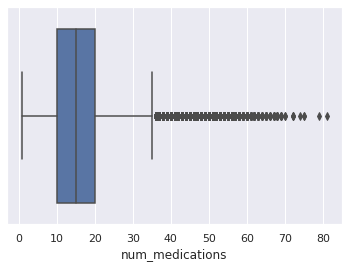

In [ ]:
sns.boxplot(df['num_medications'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


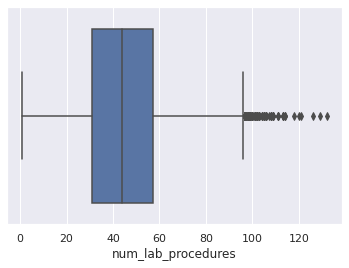

In [ ]:
sns.boxplot(df['num_lab_procedures'])

# A13
<!-- Drop outliers, only for numerical data -->

In [ ]:
# z_scores = stats.zscore(df)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# new_df = df[filtered_entries]

# print(new_df)

# B1
<!-- Mark categorical features. -->

In [ ]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

# B2
<!-- Define target and sensitive attributes. -->

In [ ]:
# Define target and sensitive attributes.
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]

Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

# B3
<!-- Drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies"). -->

In [ ]:
# Drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

X = pd.get_dummies(df.drop(columns=[
    "race",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

# C1
<!-- Next, we split the data into training and test. -->

In [ ]:
random_seed = 445
np.random.seed(random_seed)

X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

# C2
<!-- Balance dataset -->
<!-- Our performance metric is balanced accuracy, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).

Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy. -->

Our performance metric is balanced accuracy, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).

Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

print("Before: " + str(X_train.shape[0]) + " records.")
print("After: " + str(X_train_bal.shape[0])+ " records.")

Before: 50883 records.
After: 11356 records.


# C3
<!-- Train the model -->

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train_bal, Y_train_bal)

Y_pred_proba = pipeline.predict_proba(X_test)[:,1] 
Y_pred = pipeline.predict(X_test)                  

# C4 
<!-- Evaluate model -->

Check model performance on test data.

In [ ]:
print("Balanced accuracy score: " + str(balanced_accuracy_score(Y_test, Y_pred)))
print("ROC AUC score: " + str(roc_auc_score(Y_test, Y_pred)))
print("Accuracy score: " + str(accuracy_score(Y_test, Y_pred)))
print("Recall score: " + str(recall_score(Y_test, Y_pred)))
print("Confusion matrix: \n" + str(confusion_matrix(Y_test, Y_pred)))

Balanced accuracy score: 0.5762318412560716
ROC AUC score: 0.5762318412560715
Accuracy score: 0.5876422380755851
Recall score: 0.5615425250924458
Confusion matrix: 
[[26712 18492]
 [ 2490  3189]]


In [ ]:
roc_curve(Y_test, Y_pred)

(array([0.        , 0.40907884, 1.        ]),
 array([0.        , 0.56154253, 1.        ]),
 array([2, 1, 0]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


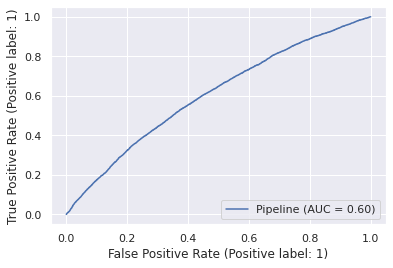

In [ ]:
# Plot roc curve
plot_roc_curve(pipeline, X_test, Y_test)